# Building more complex models in NeuroDyn

## Overview

In the "NeuroDyn model" notebook we have learned how we can define Hodgkin-Huxley and NeuroDyn models, how to simulate them, as well as how to fit the parameters of the NeuroDyn model in order to replicate the biophysical data of the squid giant axon.

Although the forms of the NeuroDyn currents are fixed to the forms of the three currents of the original Hodgkin-Huxley paper, the chip offers full flexibility in defining the dynamics of the gating variables, as well as changing the conductance parameters such as maximal conductances and reversal potentials. This flexibility allows us to use the NeuroDyn equations to replicate different types of neurons. This notebook provides an introduction to understanding how more complex biological neurons can be replicated within the NeuroDyn architecture.

We start with a biological motivation, by considering the famous model of a bursting neuron Aplysia R-15 and how its dynamical structure leads to the generation of bursts of spikes. Next, we try to mimick this basic dynamical structure using purely a short-circuit interconnection of Hodgkin-Huxley models. We finally consider how the same interconnection can be realized using a short-circuit interconnection of NeuroDyn neurons instead.

## Neuronal bursting

Bursting is one of the fundamental signalling modes of neurons and is ubiquitous in many different types of neurons and neural networks. Importantly, generating a burst of spikes after a hyperpolarizing current pulse is a crucial mechanism for the generation of intrinsic rhythms in half-center oscillators, which themselves are the building blocks of more complex central pattern generating networks.

Intrinsic generation of bursts of spikes stems from the interplay of fast processes that generate individual spikes and the slower processes that modulate the spiking behavior and define the burst duration. You can read more about the details of conductance-based modelling of bursting neurons in the **biophysics notebook**, as well as from a simplified dynamical analysis of reduced neuronal models in the **iv notebook**.

We have seen in the previous notebook how NeuroDyn can be set up to replicate the spiking behavior of the Hodgkin-Huxley model. In contrast, bursting models of neurons are generally more complex, consisting of several additional ionic currents that modulate the slower burst-generating process. These currents are mostly calcium-dependent and act to initiate and terminate the fast spike-generating processes dictated by the sodium and potassium currents.

Since we cannot add additional ionic currents to a single NeuroDyn neuron, we can achieve a similar affect by *interconnecting* several NeuroDyn neurons through resistive connections or short circuits.

To motivate this, let's first look at an example model of bursting and understand how the slower currents compare to the faster currents of the Hodgkin-Huxley model.

### Example model (Aplysia R-15)

As an example, let's take a look at the Aplysia R-15 bursting neuronal model, a well-studied bursting neuron. The membrane equation has five ionic currents: the leak, sodium and potassium currents that are common to the Hodgkin-Huxley model, and in addition, an inward calcium current and an outward calcium-activated potassium current. The calcium current is slower than the potassium current and its activation has an *excitatory* effect, while the calcium-activated potassium current is significantly slower than this and has an *inhibitory* effect.

The calcium and the calcium-activated potassium can be thought of as playing the roles of the standard sodium and potassium currents respectively, but in a *slower* timescale. This way, we can think of these currents being responsible for *slow excitability*, i.e. the generation of slow spikes, in contrast to the Hodgkin-Huxley currents, which generate fast spikes and therefore give rise to the *fast excitability*.

This **fast + slow** structure is what we aim to recreate through the interconnection of basic Hodgkin-Huxley or NeuroDyn blocks.

Let's take a look at the model to get a clearer picture of this. First, let's check the time plot of the membrane equation to see how the neuron behaves:

<ipython-input-10-d7c732c35026>:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dy = np.array([dV, dh, dn, dx, dc])
<ipython-input-10-d7c732c35026>:58: RuntimeWarning: invalid value encountered in double_scalars
  y = alphafun(V,x) / (alphafun(V,x) + betafun(V,x))
<ipython-input-10-d7c732c35026>:117: RuntimeWarning: divide by zero encountered in true_divide
  dn = (x_inf(V,'n') - n) / tau(V,'n')
C:\Users\Luka\anaconda3\lib\site-packages\scipy\integrate\_ivp\rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


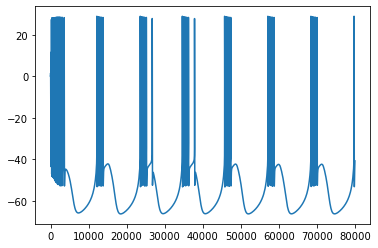

In [10]:
# Aplysia R-15 neuronal model
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# Alpha activation function for variable x
def alphafun(V, x):
    if (x == 'm'):
        y = np.zeros(np.size(V))
        V = np.array(V)
        y[V != 50] = 0.1 * (50 - V) / (np.exp((50 - V)/10) - 1)
        y[V == 50] = 1
        
    if (x == 'h'):
        y = 0.07 * np.exp((25-V)/20)
    
    if (x == 'n'):
        y = np.zeros(np.size(V))
        V = np.array(V)
        y[V != 55] = 0.01 * (55 - V) / (np.exp((55 - V)/10) - 1)
        y[V == 55] = 0.1
            
    return y

# Beta activation function for variable x
def betafun(V, x):
    if (x == 'm'):
        y = 4 * np.exp((25-V)/18)

    if (x == 'h'):
        y = 1 / (np.exp((55-V)/10) + 1)

    if (x == 'n'):
        y = 0.125 * np.exp((45-V)/80)
    
    return y

# x_inf(V) function for variable 'x'
def x_inf(V, x):
    # Define constants for gating variable 'x'
    A = 0.15
    B = -50

    # Shifted voltage constants
    C1 = 127 / 105
    C2 = 8265 / 105
    
    # Constant for Ca dynamics
    Kc = 0.0085
    
    if (x == 'x'):
        y = 1 / (np.exp(A * (B - V)) + 1)
    elif(x == 'c'):
        c = (Kc / (np.exp(A * (B - V)) + 1)) * (Eca - V)
        y = c / (0.5 + c)
    else:
        V = C1*V + C2
        y = alphafun(V,x) / (alphafun(V,x) + betafun(V,x))
    
    return y

# tau(V) function for variable 'x'
def tau(V, x):  
    # Shifted voltage constants
    C1 = 127 / 105
    C2 = 8265 / 105

    if (x == 'x'):
        y = np.ones(np.size(V)) * 235
    elif (x == 'c'):
        y = np.ones(np.size(V)) * 1 / 0.003
    else:
        # If x == 'n' or x == 'h'
        V = C1*V + C2
        y = 12.5 / (alphafun(V,x) + betafun(V,x)) # includes *1/lambda = 12.5
    
    return y

# Calcium dynamics constants
rho = 0.0003
Kc = 0.0085

# Maximum conductances in mmho/ cm^2
gna = 4
gk = 0.3
gca = 0.004
gkca = 0.03
gl = 0.003

# Nernst potentials in mV
# Note: resting potential != 0mV, not normalized as in Hodgkin-Huxley
Ena = 30
Ek = -75
Eca = 140
El = -40

# Constant current stimulus (in uA / cm^2)
I0 = 0

def Iapp(t):
    return I0

# Length of simulation (in ms)
T = 80*1000
t = (0, T)

# Initial state x = [V0, h0, n0, x0, c0]
y0 = np.array([0, 0, 0, 0, 0])

# Dynamics of the model
def ode(t, y):
    V, h, n, x, c = y
    I = Iapp(t)
    
    dV = -gna * x_inf(V,'m')**3 * h * (V - Ena) - gca * x * (V - Eca) - (gk*n**4 + gkca * c / (0.5 + c)) * (V - Ek) -gl * (V - El) + I
    dh = (x_inf(V,'h') - h) / tau(V,'h')
    dn = (x_inf(V,'n') - n) / tau(V,'n')
    dx = (x_inf(V,'x') - x) / tau(V,'x')
    dc = rho * (Kc*x*(Eca - V) - c)
    
    dy = np.array([dV, dh, dn, dx, dc])
    
    return dy

# Simulate the model
sol = solve_ivp(ode, t, y0)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.show()

As we can see, the neuron generates a bursting waveform without an external stimulus. Let's take a look at the gating variable forms to get a better idea of the underlying dynamics. Let's first look at the steady-state functions of the gating variables.

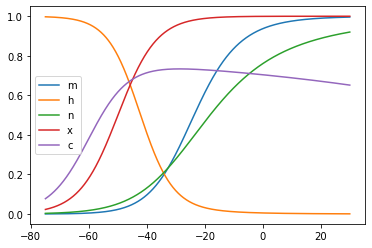

In [25]:
V = np.arange(Ek, Ena, 0.1)

plt.figure()
plt.plot(V, x_inf(V, 'm'), label='m')
plt.plot(V, x_inf(V, 'h'), label='h')
plt.plot(V, x_inf(V, 'n'), label='n')
plt.plot(V, x_inf(V, 'x'), label='x')
plt.plot(V, x_inf(V, 'c'), label='c')

plt.legend()
plt.show()

Importantly, notice that the activation of the calcium current $x$, and the activation of the calcium-activated potassium current $c$ activate at a lower voltage compared to the activation of sodium $m$ and activation of potassium $n$. Let's take a look at this seperately:

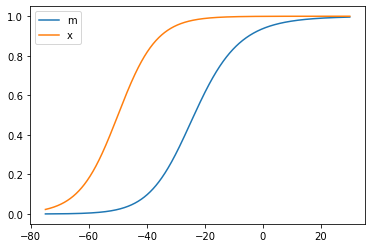

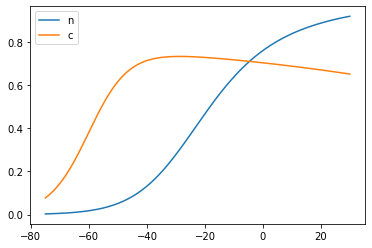

In [50]:
plt.figure()
plt.plot(V, x_inf(V, 'm'), label='m')
plt.plot(V, x_inf(V, 'x'), label='x')
plt.legend()

plt.figure()
plt.plot(V, x_inf(V, 'n'), label='n')
plt.plot(V, x_inf(V, 'c'), label='c')
plt.legend()

plt.show()

We can see that both slow gating variables activate at *lower* voltages than the faster gating variables of sodium and potassium. This ensures that the threshold of the slow spiking is lower than the threshold of the fast spiking.

Now, let's take a look at the time-constants of the gating variables:

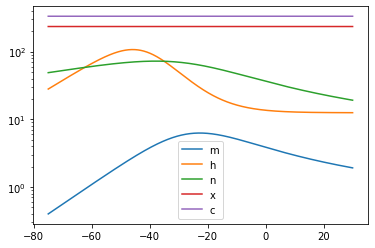

In [51]:
V = np.arange(Ek, Ena, 0.1)

plt.figure()
plt.semilogy(V, tau(V, 'm'), label='m')
plt.semilogy(V, tau(V, 'h'), label='h')
plt.semilogy(V, tau(V, 'n'), label='n')
plt.semilogy(V, tau(V, 'x'), label='x')
plt.semilogy(V, tau(V, 'c'), label='c')

plt.legend()
plt.show()

We can clearly see the separation of the timescales: the activation of the calcium and calcium-activated potassium is significantly slower than the gating variables of the Hodgkin-Huxley currents. Let's take a look again one by one, comparing sodium with calcium, and potassium with calcium-activated potassium:

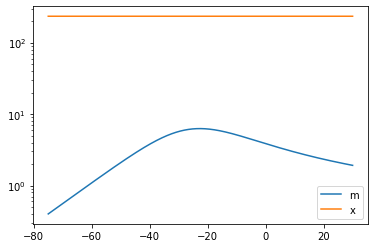

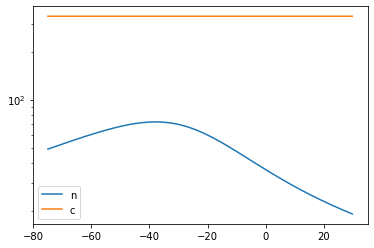

In [52]:
plt.figure()
plt.semilogy(V, tau(V, 'm'), label='m')
plt.semilogy(V, tau(V, 'x'), label='x')
plt.legend()

plt.figure()
plt.semilogy(V, tau(V, 'n'), label='n')
plt.semilogy(V, tau(V, 'c'), label='c')
plt.legend()

plt.show()

Summarizing, we can see that bursting can be achieved by adding additional currents to the Hodgkin-Huxley equation that have a similar effect as sodium and potassium, but on a slower timescale. These currents activate in a lower voltage range, ensuring that the slow threshold is below the threshold of fast spiking. Let's see if we can recreate this structure using only interconnections of Hodgkin-Huxley neurons, changing the parameters of the additional currents so that they retain these two important properties.

## Bursting through interconnection of Hodgkin-Huxley neurons

Let's see how we can construct a bursting neurons throgh the interconnection of Hodgkin-Huxley neurons. Similar to our biological example, we would like the first neuron to act as a standard Hodgkin-Huxley model, generating *fast excitability*. In turn, the second model needs to provide the *slow excitability*, so that the interconnection of the two will lead to the creation of bursts of spikes.

### Load the model

First, let's load the model and the required modules:

In [53]:
import matplotlib.pyplot as plt
from cb_models import HHModel, NeuroDynModel, ShortCircuit

# **Ignore overflow warnings**
import numpy as np
np.warnings.filterwarnings('ignore', 'overflow')

Now let's start by defining two Hodgkin-Huxley neurons and short circuiting them. We can use the class `ShortCircuit` for this, which takes a list of neurons, and **short-circuits** them so that the membrane voltages of all the neurons are equal. 

Let's try this out on the default Hodgkin-Huxley models first. If we interconnect two identical neurons like this, the capacitance and all maximal conductance parameters will effectively be doubled. This means that by also injecting twice the current compared to the regular Hodgkin-Huxley neuron, we would expect to see the same behavior. Let's check this:

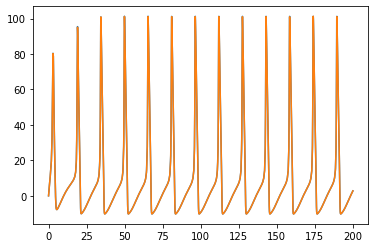

In [81]:
neuron1 = HHModel()
neuron2 = HHModel()

neuron_connection = ShortCircuit([neuron1, neuron2])

T = 200
t = (0, T)

I0 = 8
iapp1 = lambda t: I0
iapp2 = lambda t: 2*I0

x01 = [0,0,0,0]
x02 = x01 + [0,0,0]

sol1 = neuron1.simulate(t, x01, iapp1)
sol2 = neuron_connection.simulate(t, x02, iapp2)

plt.figure()
plt.plot(sol1.t, sol1.y[0])
plt.plot(sol2.t, sol2.y[0])
plt.show()

We see that the interconnection seems to work - we get the same behavior with the two-neuron interconnection as with the original neuron!

### Setting the parameters of neuron 2

Let's see now if by suitably changing the parameters of the second neuron, we can get the interconnection to burst.

#### Turning off sodium inactivation

To start, we can fix the sodium inactivation to $1$ so that it resembles more the calcium current with a single activation variable. This can be done by setting $\beta_h(V) = 0$ since then the $h$ equation becomes

\begin{equation}
\dot{h} = \alpha_h(V) (1 - h)
\end{equation}

so that the steady-state value is $h = 1$ for all $V$.


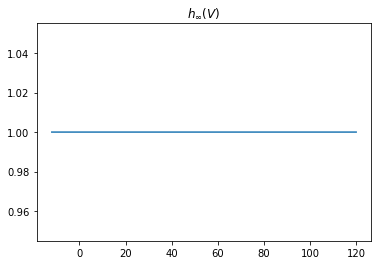

In [57]:
# Set h = 1
V = np.arange(neuron1.Ek, neuron1.Ena, 0.1)

neuron2.h.bA = 0

plt.figure()
plt.title("$h_{\infty}(V)$")
plt.plot(V, neuron2.h.inf(V))
plt.show()

#### Shifting the steady-state functions of $m$ and $n$

Now, let's shift the steady-state functions of sodium and potassium activation to a lower voltage range, so that the threshold voltage is shifted as a result. Remember that 

\begin{equation}
m_{\infty}(V) = \frac{\alpha(V)}{\alpha(V) + \beta(V)}
\end{equation}

so that by adding the same voltage shift to $\alpha(V)$ and $\beta(V)$ functions will shift $m_{\infty}(V)$ by the same amount.

We can do that by changing the parameter $V_h$ of the $m$ and $n$ variables, which represents the half-activation voltage. We need to change this parameter for both $\alpha(V)$ and $\beta(V)$ functions, so the corresponding variable names are `aVh` and `bVh`.

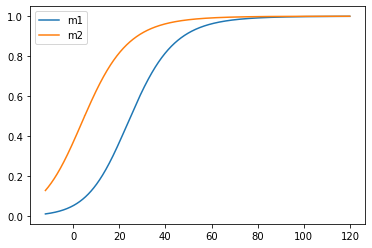

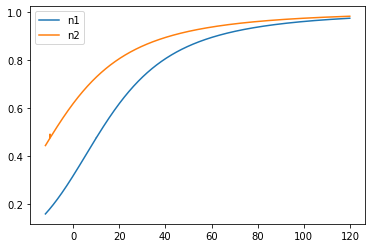

In [208]:
# Shift m and n for neuron 2
vshift = 20

# Shift m
neuron2.m.aVh = neuron1.m.aVh - vshift
neuron2.m.bVh = neuron1.m.bVh - vshift

# Shift n
neuron2.n.aVh = neuron1.n.aVh - vshift
neuron2.n.bVh = neuron1.n.bVh - vshift

plt.figure()
plt.plot(V, neuron1.m.inf(V), label = 'm1')
plt.plot(V, neuron2.m.inf(V), label = 'm2')
plt.legend()
plt.show()

plt.figure()
plt.plot(V, neuron1.n.inf(V), label = 'n1')
plt.plot(V, neuron2.n.inf(V), label = 'n2')
plt.legend()
plt.show()

#### Scaling the time constants of $m$ and $n$

The changes we have done so far had no effect on the timescales of the gating variables $m$ and $n$ and purely affected the steady-state functions. Let's now scale the time constants of the activation variables so that they activate slowly compared to the original. Remember that the time constant functionts are defined as

\begin{equation}
\tau(V) = \frac{1}{\alpha(V) + \beta(V)}
\end{equation}

so that for example multiplying both $\alpha(V)$ and $\beta(V)$ by $0.1$ will make the time constant $10$ times larger.

We can again do this by scaling the gain constants of the $\alpha(V)$ and $\beta(V)$ functions, represented by the parameters `aA` and `bA` within the gating variables.

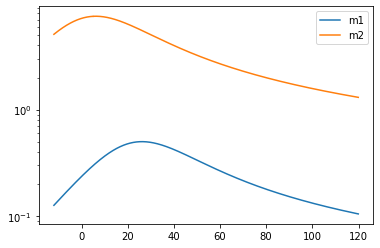

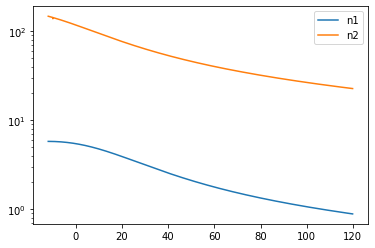

In [209]:
# Scaling the time constants for m and n in neuron 2
t_scale1 = 15
t_scale2 = 30

# Scale the timescale for neuron 2 m variable
neuron2.m.aA = neuron1.m.aA / t_scale1
neuron2.m.bA = neuron1.m.bA / t_scale1

# Scale the timescale for neuron 2 n variable
neuron2.n.aA = neuron1.n.aA / t_scale2
neuron2.n.bA = neuron1.n.bA / t_scale2

plt.figure()
plt.semilogy(V, neuron1.m.tau(V), label = 'm1')
plt.semilogy(V, neuron2.m.tau(V), label = 'm2')
plt.legend()
plt.show()

plt.figure()
plt.semilogy(V, neuron1.n.tau(V), label = 'n1')
plt.semilogy(V, neuron2.n.tau(V), label = 'n2')
plt.legend()
plt.show()

Finally, we need to change the maximal conductance parameters, as well as the reversal potentials.

Firstly, we can set the maximal conductance of the leak to $0$ since the leak current will be provided by the first neuron. Secondly, we can set the reversal potential for the sodium current to be higher, so that it reflects the calcium reversal potential. For the potassium current, we keep the same reversal potential as we are trying to emulate a slow current that still depends on potassium ions.

The maximal conductance parameters of the sodium and potassium we can use as the control variables in order to tune the bursting oscillation.

In [218]:
# Turn off leak current for neuron 2 
neuron2.gl = 0

# Set reversal potential for neuron 2 sodium to calcium reversal
neuron2.Ena = 200

# Change maximal conductances of sodium and potassium for neuron 2
neuron2.gna = 5
neuron2.gk = 13

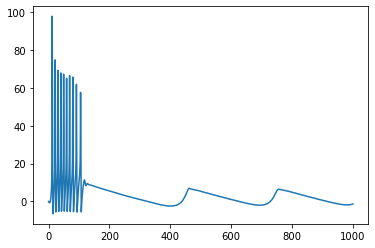

In [220]:
T = 1000
t = (0, T)

I0 = -4
iapp = lambda t: I0

x0 = [0,0,0,0,0,0,0]

sol = neuron_connection.simulate(t, x0, iapp)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.show()

## Short-circuiting NeuroDyn neurons

Let's try creating a bursting neuron by configuring two NeuroDyn neurons so that the first one provides the fast spike-generating currents, and the second one provides the slow wave-generating currents. We will then short-circuit the two neurons, effectively creating a new neuron with *six* currents ($2x \ [I_l, I_{Na}, I_K]$).

**Remember** that when we short-circuit two neurons like these, the effective membrane capacitance **doubles** due to the parallel interconnection of the membrane capacitors. This effectively doubles the membrane time constant.

Next, let's define two NeuroDyn models with different parameters and short-circuit them:

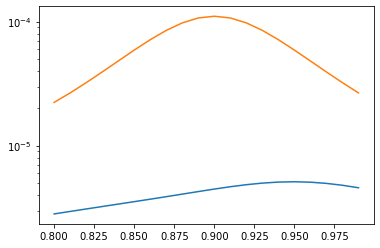

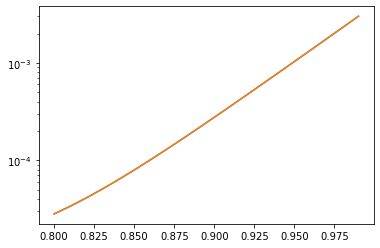

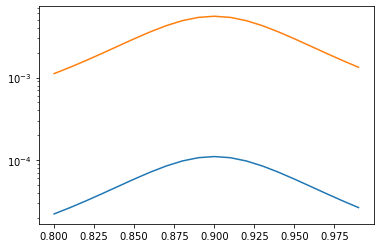

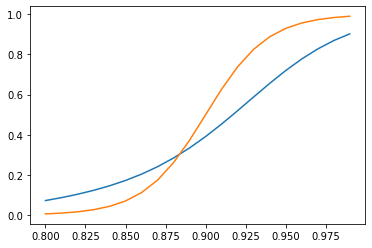

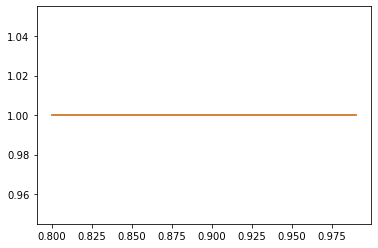

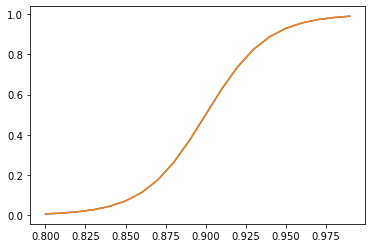

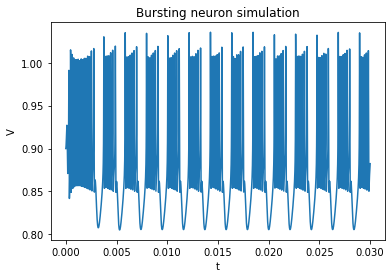

In [8]:
# parameters from joe's simulations

# Maximal conductances
dg1 = np.array([500, 500, 12])
dg2 = np.array([500, 500, 0])

# Reversal potentials
#dE1 = np.array([500, -1000, -100])
#dE2 = np.array([350, -1000, 0])
dE1 = np.array([550, -1000, -250])
dE2 = np.array([350, -900, 0])


# Sigmoid biases
#dIbm = np.array([[0, 0, 0, 0, 1000, 0, 0], [0, 0, 1000, 0, 0, 0, 0]])
#dIbh = np.array([[0, 0, 400, 0, 0, 0, 0], [0, 0, 0, 0, 320, 0, 0]])
#dIbn = np.array([[0, 0, 0, 0, 320, 0, 0], [0, 0, 400, 0, 0, 0, 0]])
dIbm = np.array([[0, 0, 120, 400, 1023, 0, 0], [0, 0, 1023, 1023, 0, 0, 0]])
dIbh = np.array([[0, 0, 400, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]])
dIbn = np.array([[0, 0, 0, 0, 500, 0, 0], [0, 0, 500, 0, 0, 0, 0]])

dIb1 = [dIbm, dIbh, dIbn]

sf = 2.0
#dIbm = np.array([[0, 0, 0, 0, 320, 0, 0], [0, 0, 400, 0, 0, 0, 0]])
#dIbh = np.array([[0, 0, 400, 0, 0, 0, 0], [0, 0, 0, 0, 320, 0, 0]])
#dIbn = np.array([[0, 0, 0, 0, 10//sf, 0, 0], [0, 0, 10//sf, 0, 0, 0, 0]])

dIbm = np.array([[0, 0, 0, 0, 500, 0, 0], [0, 0, 500, 0, 0, 0, 0]])
dIbh = np.array([[0, 0, 400, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]])
dIbn = np.array([[0, 0, 0, 0, 10, 0, 0], [0, 0, 10, 0, 0, 0, 0]])

dIb2 = [dIbm, dIbh, dIbn]

# Analog values (same for both)
V_ref = 0.9
I_master = 33e-9
I_voltage = 230e-9
I_ref = 100e-9

# Create two neurons with different parameters
capacitance_scaling = 0.1 # scale the capacitance to increase the dynamic range

neuron1 = NeuroDynModel(dg1, dE1, dIb1, V_ref, I_voltage, I_master, I_ref, capacitance_scaling)
neuron2 = NeuroDynModel(dg2, dE2, dIb2, V_ref, I_voltage, I_master, I_ref, capacitance_scaling)

# Short circuit the neurons
bursting_neuron = ShortCircuit([neuron1, neuron2])

# Plot the gating variable functions
V = np.arange(V_ref - 0.1, V_ref + 0.1, 0.01)

# Tau functions
plt.figure()
plt.semilogy(V, neuron1.m.tau(V), V, neuron2.m.tau(V))
plt.figure()
plt.semilogy(V, neuron1.h.tau(V), V, neuron2.h.tau(V))
plt.figure()
plt.semilogy(V, neuron1.n.tau(V), V, neuron2.n.tau(V))

# Steady-state functions
plt.figure()
plt.plot(V, neuron1.m.inf(V), V, neuron2.m.inf(V))
plt.figure()
plt.plot(V, neuron1.h.inf(V), V, neuron2.h.inf(V))
plt.figure()
plt.plot(V, neuron1.n.inf(V), V, neuron2.n.inf(V))

I0 = 0e-10
Iapp = lambda t: I0

T = 0.03
trange = (0, T)

sol = bursting_neuron.simulate(trange,[V_ref,0,0,0,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Bursting neuron simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

## Post-inhibitory rebound



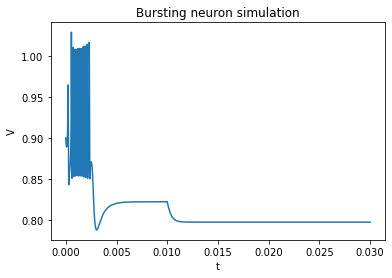

In [20]:
def pulse(t, t_start, t_length, mag):
    I = (t>=t_start)*mag - (t>=(t_start+t_length))*mag
    return I

I0 = 8e-12
Iapp = lambda t: I0 - pulse(t, 0.01, 0.005, 5e-11)

T = 0.03
trange = (0, T)

sol = bursting_neuron.simulate(trange,[V_ref,0,0,0,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Bursting neuron simulation')
plt.plot(sol.t, sol.y[0])
plt.show()